## lasso回归
- 使用L1 正则化项的线性回归

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [69]:
class LassoRegression(object):
    def __init__(self, learning_rate = 0.1, epochs = 500, verbose=False, lam=0.5):
        self.theta = None
        self.b = None
        self.alpha = learning_rate
        self.epochs = epochs
        self.verbose = verbose
        self.lam = lam
    def train(self, train_x, train_y):
        if len(train_y.shape) == 1:
            train_y = train_y.reshape(-1, 1)
        m , n = train_x.shape
        np.random.seed(78)
        mu = 0.4
        sigma = 0.8
        self.theta = sigma*np.random.randn(1,n)+mu
        self.b = np.random.random()
#         self.theta = np.zeros((1,n))
#         self.b = 0.
        for i in xrange(self.epochs):
            pre_y = self.predict(train_x)
            delta_l1 = np.ones_like(self.theta)
            delta_l1[self.theta < 0] = -1
            d_theta = np.mean((pre_y - train_y)*train_x,axis=0) \
                                                + self.lam * delta_l1
            d_b    = np.mean(pre_y - train_y, axis=0)
            self.theta -= self.alpha * d_theta
            self.b     -= self.alpha * d_b
            if self.verbose is True and (i+1) % 100 == 0:
                print "the %d epoch, the W is %d and the b is %d" \
                % (i, self.theta, self.b)
    def fit(self, train_x, train_y):
        self.train(train_x, train_y)
    def predict(self, x):
        """
        type sita:([[]])
        type b:float
        type X:([[]])
        rtype:([[]])
        """
        pre = np.dot(x , self.theta.T) + self.b
        return pre

In [28]:
def load_data():
    n_samples, n_features = 50, 200
    X = np.random.randn(n_samples, n_features)
    coef = 3 * np.random.randn(n_features)
    inds = np.arange(n_features)
    np.random.shuffle(inds)
    coef[inds[10:]] = 0  # sparsify coef
    y = np.dot(X, coef)

    # add noise
    y += 0.01 * np.random.normal(size=n_samples)

    # Split data in train set and test set
    n_samples = X.shape[0]
    X_train, y_train = X[:n_samples // 2], y[:n_samples // 2]
    X_test, y_test = X[n_samples // 2:], y[n_samples // 2:]
    
    return X_train, X_test, y_train, y_test, coef

In [74]:
def regression(train_x, train_y, test_x, test_y, coef):
    lam = 0.2
    lasso = LassoRegression(learning_rate=0.001, epochs=10000, verbose=False, lam=lam)
    lasso.fit(train_x, train_y)
    y_pre = lasso.predict(test_x)
    r2_score_lasso = r2_score(test_y, y_pre)
    print("r^2 on test data : %f" % r2_score_lasso)
    
    plt.figure(figsize=(12, 7))
    plt.plot(lasso.theta.flatten(), color='gold', linewidth=2,label='Lasso coefficients')
    plt.plot(coef, '--', color='navy', label='original coefficients')
    plt.legend(loc='best')
    plt.title("Lasso R^2: %f" % (r2_score_lasso))

In [32]:
train_x, test_x, train_y, test_y, coef = load_data()

In [33]:
print train_x.shape
print test_x.shape

(25, 200)
(25, 200)


r^2 on test data : 0.155488


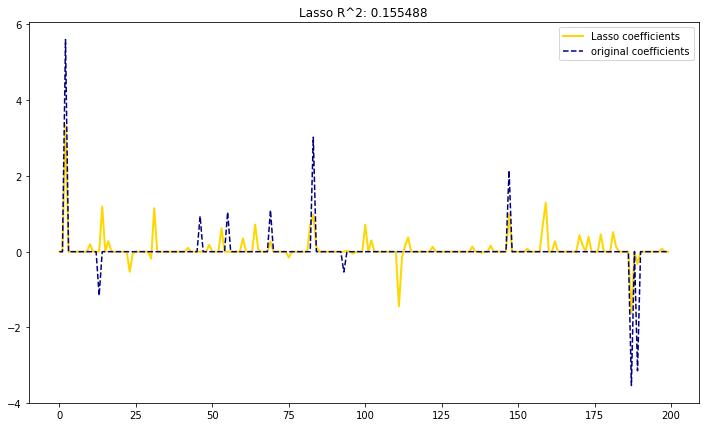

In [75]:
regression(train_x, train_y, test_x, test_y, coef)